In [1]:
from src.lindbladAG import mesolveAG
import numpy as np
from qutip import Qobj, basis, brmesolve
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
plt.style.use("https://johannesfeist.eu/misc/jf_cb.mplstyle")

text explaining stuff

# Comparison with qutip's brmesolve (no cross-correlations and no Lamb-shift)

In [2]:
# Parameters

# size of system
nLevels = 4
nOperators = 2

# fix the seed for reproducibility
np.random.seed(123456789)

# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels))*0.1 + h.T*0.1 + np.diag(np.diagonal(h)))
evals = H.eigenenergies()

# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    op -= np.diag(np.diagonal(op))
    a_ops.append(Qobj(op))

text explaining stuff about bath functions

Text(0, 0.5, '$\\hbar J_i$ (eV)')

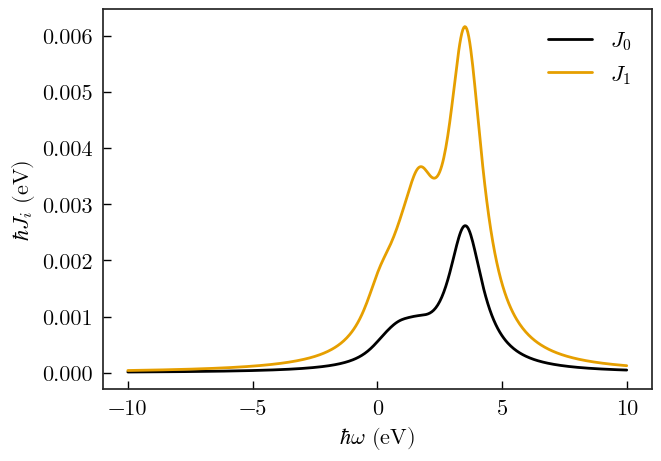

In [3]:
# Bath spectral functions

# number of modes
nModes = 10

# mode energies
energies = np.random.rand(nModes) * (2*max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)

# mode couplings
couplings = np.random.rand(nModes, nModes) * 0.5
for i in range(nModes): couplings[i, i] = 0
couplings = (couplings + couplings.T) * 0.5

# decay rate of each mode
κi = np.random.rand(nModes) * (0.5 - 0.2) + 1.5

# matrix 
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)

# mode "field strengths" as felt by each emitter operator
g = np.random.rand(nOperators, nModes) * np.sqrt(0.01)

# spectral density: create an array and interpolate it to obtain callable objects
# J_arr is a matrix J[w, i, j]
frequency = np.linspace(-10, 10, 500)
J_arr = 1 / np.pi * g @ np.linalg.inv(h - frequency[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
# J is an array of interpolators of J_arr.
# we remove the bath cross-correlations by keeping only the diagonal elements of J_arr and interpolating
J = np.empty(nOperators, dtype=object)
for i in range(nOperators):
    J[i] = interp1d(frequency, J_arr[:, i, i], bounds_error=False, fill_value=0) 
    plt.plot(frequency, J[i](frequency), label=f"$J_{i}$")
plt.legend()
plt.xlabel("$\hbar\omega$ (eV)")
plt.ylabel("$\hbar J_i$ (eV)")

In [4]:
# Time evolution:

# initial state: chosen randomly
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()

# time array
t = np.linspace(0, 200, 1500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Bloch-Redfield
# the definition of the spectral functions in qutip is S = 2πJ. The 2π can be included in the operators with a square root.
a_opsBR = [[np.sqrt(2*np.pi)*a, j] for a, j in zip(a_ops, J)]
rhoBR = brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_opsBR, e_ops=e_ops, use_secular=False).expect

# 2. Arithmetic-Geometric master equation
# comparable syntax. use_secular=False is the default option here.
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, J=J, e_ops=e_ops, use_secular=False).expect

[[1.41776198 0.80803323 0.97222526 1.41887856]
 [0.80803323 1.13471828 0.42964473 2.16830813]
 [0.97222526 0.42964473 1.34352387 0.98638103]
 [1.41887856 2.16830813 0.98638103 3.87393847]]
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


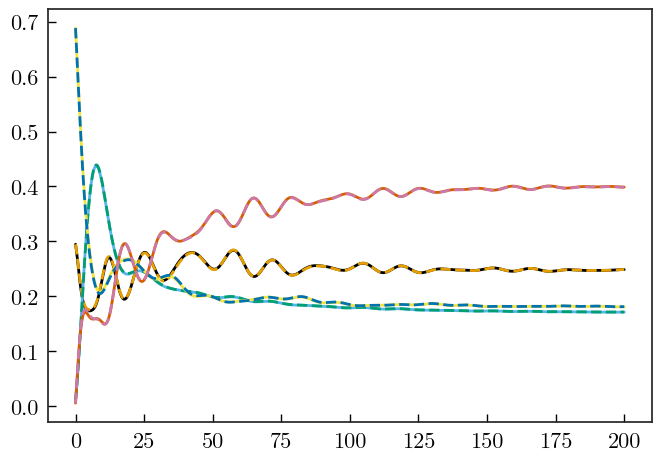

In [5]:
for pBR, pAG in zip(rhoBR, rhoAG):
    plt.plot(t, pBR.real)
    plt.plot(t, pAG.real, "--")

# Lamb shift

implement lamb shift part for BR (old version)

In [18]:
# Parameters

# size of system
nLevels = 3
nOperators = 2

# fix the seed for reproducibility
np.random.seed(987654321)

# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels))*0.1 + h.T*0.1 + np.diag(np.diagonal(h)))
H = Qobj(np.diag(np.diagonal(h)))
evals = H.eigenenergies()


# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    op -= np.diag(np.diagonal(op))
    a_ops.append(Qobj(op))

Text(0, 0.5, '$\\hbar J_i\\ \\mathrm{and}\\ \\hbar\\Lambda_i$ (eV)')

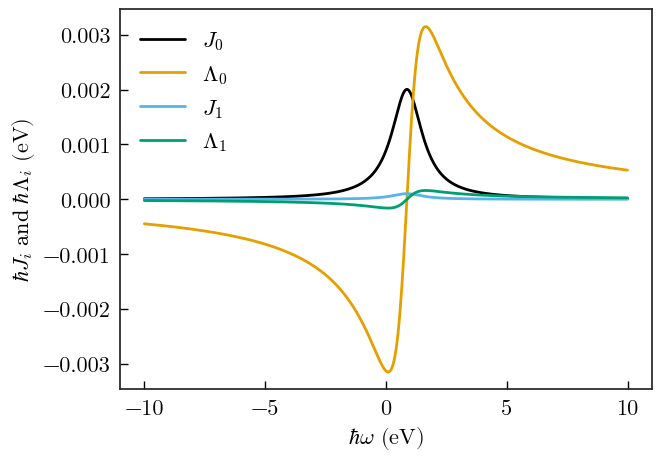

In [19]:
# Bath spectral functions

# number of modes
nModes = 1

# mode energies
energies = np.random.rand(nModes) * (2*max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)

# mode couplings
couplings = np.random.rand(nModes, nModes) * 0.5
for i in range(nModes): couplings[i, i] = 0
couplings = (couplings + couplings.T) * 0.5

# decay rate of each mode
κi = np.random.rand(nModes) * (0.5 - 0.2) + 1.5

# matrix 
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)

# mode "field strengths" as felt by each emitter operator
g = np.random.rand(nOperators, nModes) * np.sqrt(0.01)

# spectral density: create an array and interpolate it to obtain callable objects
# J_arr is a matrix J[w, i, j]
frequency = np.linspace(-10, 10, 500)
J_arr = 1 / np.pi * g @ np.linalg.inv(h - frequency[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
L_arr = - g @ np.linalg.inv(h - frequency[:, np.newaxis, np.newaxis] * np.identity(nModes)).real @ g.T
# J is an array of interpolators of J_arr.
# we remove the bath cross-correlations by keeping only the diagonal elements of J_arr and interpolating
J = np.empty(nOperators, dtype=object)
L = np.empty(nOperators, dtype=object)
for i in range(nOperators):
    J[i] = interp1d(frequency, J_arr[:, i, i], bounds_error=False, fill_value=0) 
    L[i] = interp1d(frequency, L_arr[:, i, i], bounds_error=False, fill_value=0) 
    plt.plot(frequency, J[i](frequency), label=f"$J_{i}$")
    plt.plot(frequency, L[i](frequency), label=f"$\Lambda_{i}$")
plt.legend()
plt.xlabel("$\hbar\omega$ (eV)")
plt.ylabel("$\hbar J_i\ \mathrm{and}\ \hbar\Lambda_i$ (eV)")

In [20]:
# Time evolution:

# initial state: chosen randomly
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()

# time array
t = np.linspace(0, 200, 1500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Bloch-Redfield
# the definition of the spectral functions in qutip is S = 2πJ. The 2π can be included in the operators with a square root.
a_opsBR = [[np.sqrt(2*np.pi)*a, j] for a, j in zip(a_ops, J)]
rhoBR = brmesolve(H=H, psi0=psi0, tlist=t, a_ops=a_opsBR, e_ops=e_ops, use_secular=False).expect

# 2. Arithmetic-Geometric master equation
# comparable syntax. use_secular=False is the default option here.
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, J=J, L=L, e_ops=e_ops, use_secular=False).expect

[[0.         1.69881838 1.78170964]
 [1.69881838 0.         1.36295336]
 [1.78170964 1.36295336 0.        ]]
[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
0 [1.66569265+0.j 0.3338441 +0.j] 0 [1.66569265+0.j 0.3338441 +0.j]
0 [1.66569265+0.j 0.3338441 +0.j] 1 [0.5853597 +0.j 1.68280814+0.j]
0 [1.66569265+0.j 0.3338441 +0.j] 2 [1.66569265+0.j 0.3338441 +0.j]
0 [1.66569265+0.j 0.3338441 +0.j] 3 [1.22233744+0.j 0.60293701+0.j]
0 [1.66569265+0.j 0.3338441 +0.j] 4 [0.5853597 +0.j 1.68280814+0.j]
0 [1.66569265+0.j 0.3338441 +0.j] 5 [1.22233744+0.j 0.60293701+0.j]
1 [0.5853597 +0.j 1.68280814+0.j] 0 [1.66569265+0.j 0.3338441 +0.j]
1 [0.5853597 +0.j 1.68280814+0.j] 1 [0.5853597 +0.j 1.68280814+0.j]
1 [0.5853597 +0.j 1.68280814+0.j] 2 [1.66569265+0.j 0.3338441 +0.j]
1 [0.5853597 +0.j 1.68280814+0.j] 3 [1.22233744+0.j 0.60293701+0.j]
1 [0.5853597 +0.j 1.68280814+0.j] 4 [0.5853597 +0.j 1.68280814+0.j]
1 [0.5853597 +0.j 1.68280814+0.j] 5 [1.22233744+0.j 0.60293701+0.j]
2 [1.66569265+0.j 0.333844

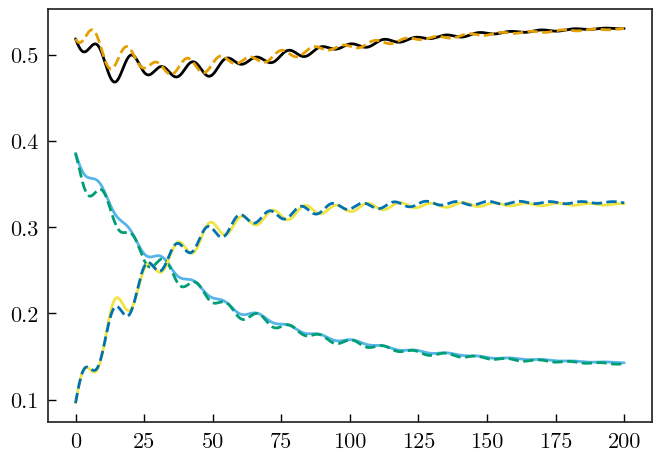

In [21]:
for pBR, pAG in zip(rhoBR, rhoAG):
    plt.plot(t, pBR.real)
    plt.plot(t, pAG.real, "--")